# Real or Not? NLP with Disaster Tweets - Analysis and Predictions with LSTM Neural Network
### Methodology inspired by [this article](https://medium.com/real-or-not-nlp-with-disaster-tweets/real-or-not-nlp-with-disaster-tweets-a-data-science-capstone-project-fafa6c35c16f) on Medium and two Kaggle notebooks [here](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove) and [here](https://www.kaggle.com/philculliton/nlp-getting-started-tutorial/).

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import string, expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalMaxPooling1D, Dropout, Input, BatchNormalization, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [59]:
pd.options.mode.chained_assignment = None  # default='warn'

# 1. Data Exploration

In [60]:
X_full = pd.read_csv('train.csv')
print(X_full)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

#### Missing values need to be filled in properly. Because the location feature itself is not standardized/automatically generated, we should drop it!

In [61]:
X_full = X_full.drop(['location'], axis=1)

#### Can text length be a good predictor of disasterous tweets?

In [62]:
X_full['text_length'] = X_full['text'].apply(lambda x : len(x))

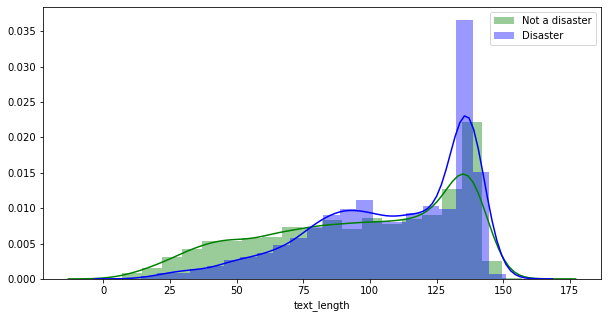

In [63]:
plt.figure(figsize=(10, 5))
sns.distplot(X_full[X_full['target'] == 0]['text_length'], color='green', label='Not a disaster')
sns.distplot(X_full[X_full['target'] == 1]['text_length'], color='blue', label='Disaster')
plt.legend()

#### Evidently, there doesn't seem to be a discernable correlation between the tweets: both disasterous and non-disasterous tweets have long and short text lengths.

# 2. Data Preprocessing
## Data preprocessing for NLP consists of cleaning and tokenizing the text.
#### a) Make all text uppercase to make sure NLP algo treats all text equally
#### b) Remove noise (punctuation, numerical values)
#### c) Stopword removal (common words)

In [64]:
def clean_text(data: 'pandas.core.frame.DataFrame') -> 'pandas.core.frame.DataFrame':
    data['text'] = data['text'].str.upper()
    #Getting all alphanumeric characters
    data['text_clean'] = np.nan
    alphanumeric = []
    for value in range(0, 128):
        if (value >= 48 and value <= 57) or (value >= 65 and value <= 90) or value == 32:
            alphanumeric.append(chr(value))
    #Making a new dataframe column that only contains strings that only have alphanumeric values.
    for i in range(data.shape[0]):
        current_string = list(data['text'][i])
        new_string = []
        for j in range(len(current_string)):
            if current_string[j] in alphanumeric:
                new_string.append(current_string[j])
        new_string = ''.join(new_string)
        data['text_clean'][i] = new_string
    return data

In [65]:
def stopword_removal(data: 'pandas.core.frame.DataFrame') -> 'pandas.core.frame.DataFrame':
    for i in range(data.shape[0]):
        #Keep only words that are not in the stopwords dictionary
        new_text = []
        sentence = data['text_clean'][i].split(' ')
        for word in sentence:
            if word.lower() not in nltk.corpus.stopwords.words('english'):
                new_text.append(word)
        new_text = ' '.join(new_text)
        data['text_clean'][i] = new_text
    return data

In [66]:
def preprocessor(data: 'pandas.core.frame.DataFrame') -> 'pandas.core.frame.DataFrame':
    data = clean_text(data)
    data = stopword_removal(data)
    return data

In [67]:
X_full = preprocessor(X_full)
#We don't need the raw text anymore, so we can drop that column
X_full = X_full.drop(['text'], axis=1)

## We split the model into training and validation data.

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full['text_clean'], X_full['target'], test_size=0.2, random_state=42)

## Tokenize the data such that it can be comprehensible by the model.

In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_valid_tokenized = tokenizer.texts_to_sequences(X_valid)

y_train = y_train.values
y_valid = y_valid.values

## Pad the data to avoid overfitting(?).

In [70]:
X_train_padded = pad_sequences(X_train_tokenized, padding='post', maxlen=100)
X_valid_padded = pad_sequences(X_valid_tokenized, padding='post', maxlen=100)

# 3. Defining NN model for text classification.

In [71]:
# %%time
# embedding_model = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
# embedding = hub.KerasLayer(embedding_model, trainable=False, name='USE_embedding')

In [72]:
# droupout = 0.5

# LSTM_model = Sequential([
#     Input(shape=[], dtype=string),
#     embedding,
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(dropout),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(dropout),
#     Dense(1, activation='sigmoid')
# ])

# LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# LSTM_model.summary()

In [73]:
embedding_dim = 100
dropout = 0.5
MAX_SEQ_LENGTH = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=MAX_SEQ_LENGTH,
              output_dim=embedding_dim,
              input_length=100))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1915600   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)              

In [74]:
hist = model.fit(X_train_padded, y_train,
                     epochs=20,
                     verbose=1,
                     validation_split=0.2,
                     batch_size=64)

Epoch 1/20
77/77 [==============================] - 4s 49ms/step - loss: 0.8415 - accuracy: 0.5866 - val_loss: 0.6860 - val_accuracy: 0.5616
Epoch 2/20
77/77 [==============================] - 4s 52ms/step - loss: 0.4487 - accuracy: 0.8161 - val_loss: 0.6719 - val_accuracy: 0.5616
Epoch 3/20
77/77 [==============================] - 4s 47ms/step - loss: 0.2207 - accuracy: 0.9197 - val_loss: 0.6527 - val_accuracy: 0.5698
Epoch 4/20
77/77 [==============================] - 4s 52ms/step - loss: 0.1162 - accuracy: 0.9616 - val_loss: 0.5642 - val_accuracy: 0.7085
Epoch 5/20
77/77 [==============================] - 4s 48ms/step - loss: 0.0751 - accuracy: 0.9774 - val_loss: 0.5388 - val_accuracy: 0.7438
Epoch 6/20
77/77 [==============================] - 4s 49ms/step - loss: 0.0547 - accuracy: 0.9842 - val_loss: 0.5653 - val_accuracy: 0.7488
Epoch 7/20
77/77 [==============================] - 4s 49ms/step - loss: 0.0383 - accuracy: 0.9895 - val_loss: 0.5853 - val_accuracy: 0.7759
Epoch 8/20
77

In [75]:
#Saving model weights
LSTM_model.save_weights('LSTM_model_20epoch_full.h5')

In [76]:
#Evaluating model accuracy
predictions = LSTM_model.predict(X_valid_padded)
predictions_norm = np.round(predictions)
y_pred = []
for p in predictions_norm:
    y_pred.append(p[0])
print(accuracy_score(y_pred, y_valid))

0.767564018384767


# 4. Making predictions using the test set.
## To make predictions using the test set, we have to load the data in, remove dirty features, clean it, and vectorize it.

In [77]:
X_test_full = pd.read_csv('test.csv')
print(X_test_full)

         id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  
0                    Just happened a terrible car crash  
1     Heard about #earthquake is different cities, s...  
2     there is a forest fire at spot pond, geese are...  
3              Apocalypse lighting. #Spokane #wildfires  
4         Typhoon Soudelor kills 28 in China and Taiwan  
...                                                 ...  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...  
3259  Storm in RI worse than last hurricane. My city...  
3260  Green Line derailment in Chicago http://t.co/U...  
3261  MEG issues Hazardous Weather 

In [78]:
X_test_full = X_test_full.drop(['keyword', 'location'], axis=1)
X_test_full = preprocessor(X_test_full)
X_test_full = X_test_full.drop(['text'], axis=1)
X_test = X_test_full['text_clean']

In [79]:
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_tokenized, padding='post', maxlen=100)

In [80]:
#Making the prediction
test_preds = LSTM_model.predict(X_test_padded)
test_preds_norm = np.round(test_preds)
preds = []
for p in test_preds_norm:
    preds.append(int(p[0]))

In [81]:
#Writing to submission file
submission = pd.DataFrame({
    'id':X_test_full['id'],
    'target':preds
})
submission.to_csv('submission.csv', index=False)